<a href="https://colab.research.google.com/github/ep51lon/LUMOS/blob/main/From_2Ds_to_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Dependencies preparation

In [ ]:
#@title Install dependencies
!sudo apt-get update -qq
!sudo apt-get install -y libboost-all-dev qtbase5-dev > /dev/null

!pip install pycolmap open3d matplotlib numpy pillow tqdm

import os
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from PIL import Image
from tqdm import tqdm
import pycolmap
from pycolmap import CameraMode, Device

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Images in project:
recon_project/images/IMG00001.jpeg
recon_project/images/IMG00002.jpeg
recon_project/images/IMG00003.jpeg
recon_project/images/IMG00004.jpeg
recon_project/images/IMG00005.jpeg
recon_project/images/IMG00006.jpeg
recon_project/images/IMG00007.jpeg
recon_project/images/IMG00008.jpeg
recon_project/images/IMG00009.jpeg
recon_project/images/IMG00010.jpeg
Total images: 10


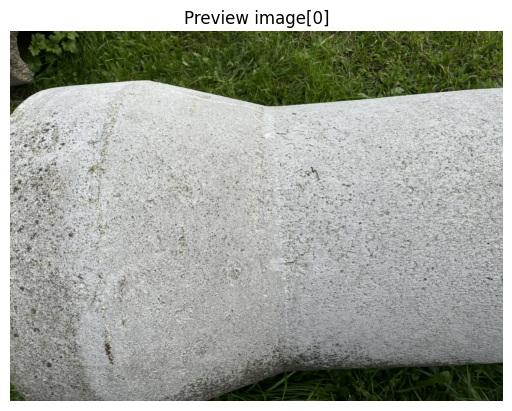

In [ ]:
#@title Prepare project directories and check images
image_dir_source = "images"  # folder gambar
assert os.path.exists(image_dir_source), "Folder 'images' belum ada. Upload foto ke folder 'images'."

project_dir = "recon_project"
images_dir = os.path.join(project_dir, "images")
db_path = os.path.join(project_dir, "database.db")
sparse_dir = os.path.join(project_dir, "sparse")

# reset project folder biar bersih
if os.path.exists(project_dir):
    shutil.rmtree(project_dir)

os.makedirs(project_dir, exist_ok=True)
os.makedirs(sparse_dir, exist_ok=True)

# salin gambar ke workspace
shutil.copytree(image_dir_source, images_dir)

# tampilkan daftar gambar
image_paths = sorted(glob.glob(os.path.join(images_dir, "*")))
print("Images in project:")
for p in image_paths:
    print(p)
print(f"Total images: {len(image_paths)}")

# preview 1 gambar
img0 = Image.open(image_paths[0])
plt.imshow(img0)
plt.title("Preview image[0]")
plt.axis("off")
plt.show()

In [ ]:
#@title Initialize empty COLMAP database (fixed)
from pycolmap import Database

if os.path.exists(db_path):
    os.remove(db_path)

db = Database(db_path)
print("Database created at:", db_path)

# Tidak perlu commit atau close di pycolmap versi baru
del db

Database created at: recon_project/database.db


In [ ]:
#@title Feature extraction (SIFT) with pycolmap
pycolmap.extract_features(
    database_path=db_path,
    image_path=images_dir,
    camera_mode=CameraMode.SINGLE,     # anggap semua foto dari kamera yang sama
    camera_model='SIMPLE_RADIAL',      # model kamera umum
    device=Device.auto                # GPU kalau ada, fallback CPU
)

print("✅ Feature extraction done.")

✅ Feature extraction done.


In [ ]:
#@title Exhaustive feature matching
pycolmap.match_exhaustive(
    database_path=db_path,
    device=Device.auto   # pakai GPU bila ada
)

print("✅ Feature matching done.")

✅ Feature matching done.


In [ ]:
#@title Incremental mapping (pose estimation + triangulation + BA) - FIXED
from pycolmap import IncrementalPipelineOptions

reconstructions = pycolmap.incremental_mapping(
    database_path=db_path,
    image_path=images_dir,
    output_path=sparse_dir,
    options=IncrementalPipelineOptions(),
)

print("Number of reconstructed models:", len(reconstructions))
if len(reconstructions) == 0:
    raise RuntimeError("Reconstruction failed. Cek apakah foto punya overlap dan tidak blur.")

# pycolmap.incremental_mapping() mengembalikan dict[int, Reconstruction]
# biasanya key-nya adalah 0 untuk model terbesar
model_ids = list(reconstructions.keys())
print("Model IDs returned:", model_ids)

recon = reconstructions[model_ids[0]]

print("✅ Reconstruction summary:")
print(" #Cameras       :", len(recon.cameras))
print(" #Images (poses):", len(recon.images))
print(" #3D points     :", len(recon.points3D))

Number of reconstructed models: 1
Model IDs returned: [0]
✅ Reconstruction summary:
 #Cameras       : 1
 #Images (poses): 10
 #3D points     : 6528


Jumlah titik 3D: 6528


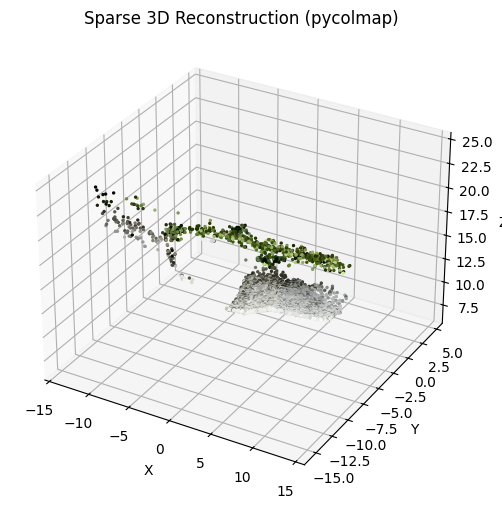

In [ ]:
#@title Visualize 3D Sparse Point Cloud Only

import numpy as np
import matplotlib.pyplot as plt

# Ambil koordinat titik 3D
pts_xyz = []
pts_col = []

for pid, p in recon.points3D.items():
    pts_xyz.append(p.xyz)

    # Ambil warna (kalau tersedia)
    if hasattr(p, "rgb"):
        col = np.array(p.rgb, dtype=np.float64) / 255.0
    elif hasattr(p, "color"):
        col = np.array(p.color, dtype=np.float64) / 255.0
    else:
        col = np.array([200, 200, 200], dtype=np.float64) / 255.0
    pts_col.append(col)

pts_xyz = np.array(pts_xyz)
pts_col = np.array(pts_col)

print(f"Jumlah titik 3D: {len(pts_xyz)}")

# Plot 3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    pts_xyz[:,0],
    pts_xyz[:,1],
    pts_xyz[:,2],
    c=np.clip(pts_col, 0, 1),
    s=2,
    depthshade=False
)

ax.set_title("Sparse 3D Reconstruction (pycolmap)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [ ]:
#@title Export Sparse Point Cloud to PLY
import open3d as o3d
import os

sparse_ply_path = os.path.join(project_dir, "sparse_pointcloud.ply")

pcd_sparse = o3d.geometry.PointCloud()
pcd_sparse.points = o3d.utility.Vector3dVector(pts_xyz)
pcd_sparse.colors = o3d.utility.Vector3dVector(np.clip(pts_col, 0, 1))

o3d.io.write_point_cloud(sparse_ply_path, pcd_sparse, write_ascii=True)
print("✅ Saved sparse point cloud to:", sparse_ply_path)

✅ Saved sparse point cloud to: recon_project/sparse_pointcloud.ply
